# Анализ поведения пользователей интернет-магазина

**Описание проекта:**  
Проект посвящен комплексному анализу поведения пользователей и покупок в интернет-магазине на основе трёх связанных датасетов: информация о пользователях, заказы и позиции товаров в заказах. 

**Цель исследования:**  
Выявление закономерностей покупательской активности, проблем с доставкой и сегментация клиентов для дальнейшего маркетинга и удержания.

**Описание данных:**  
- **Пользователи (`df`)**: `customer_id`, `customer_unique_id`, `customer_zip_code_prefix`, `customer_city`, `customer_state`  
- **Заказы (`df1`)**: `order_id`, `customer_id`, `order_status`, `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date`, `order_estimated_delivery_date`  
- **Позиции товаров (`df2`)**: `order_id`, `order_item_id`, `product_id`, `seller_id`, `shipping_limit_date`, `price`, `freight_value`  

**Содержание:**  
[1. Подготовка данных](#подготовка)  
[2. Предобработка данных](#предобработка)  
[3. Анализ данных](#анализ)  
[4. Вывод](#вывод)


**Этапы анализа:**  
- Определение пользователей, совершивших покупку только один раз  
- Анализ количества заказов по месяцам, которые не доставляются по разным причинам  
- Выявление дня недели, когда каждый товар покупается чаще всего  
- Расчет средней частоты покупок на пользователя в неделю по месяцам  
- Когортный анализ пользователей с определением когорты с максимальным retention на 3-й месяц  
- RFM-сегментация клиентов по метрикам Recency (R), Frequency (F) и Monetary (M) с построением границ метрик для каждого сегмента и интерпретацией лояльности

**Общий вывод:**  
- Выявлены одноразовые покупатели
- Количество недоставленных заказов по статусам canceled, unavailable в месяц
- Определено, в какой день недели каждый товар чаще всего покупается
- Среднее количество покупок каждого из пользователей в неделю
- Построен когортный анализ с retention по месяцам  
- Проведена RFM-сегментация клиентов для оценки лояльности и ценности клиентов

<a id="подготовка"></a>
# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

Три датасета:
1) данные по клиентам
2) данные по заказам
3) данные по товарам

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/romangalayko/personal_projects/refs/heads/main/01.project01_karpov_courses/olist_customers_dataset.csv"
)
df1 = pd.read_csv(
    "https://raw.githubusercontent.com/romangalayko/personal_projects/refs/heads/main/01.project01_karpov_courses/olist_orders_dataset.csv", 
    parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
        'order_estimated_delivery_date']
)
df2 = pd.read_csv(
    "https://raw.githubusercontent.com/romangalayko/personal_projects/refs/heads/main/01.project01_karpov_courses/olist_order_items_dataset.csv",
    parse_dates = ['shipping_limit_date']
)

display(df.head(3))
display(df1.head(3))
display(df2.head(3))

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [3]:
def opening (data):
        print('ПЕРВЫЕ 5 СТРОК')
        print(data.head(), '\n')
        
        print('ИНФОРМАЦИЯ О ДАННЫХ')
        data.info()
        print('\n')
        
        print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
        print(data.isna().sum(), '\n')
        
        print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %')
        print(data.isna().mean()*100, '\n')

        if not data.select_dtypes(include='number').empty:
            print('ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ')
            print(data.describe(include='number'), '\n')
        else:
            print('Числовых столбцов нет', '\n')
        
        print('УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ')
        cat_cols = data.select_dtypes(include=['object', 'category'])
        for col in cat_cols:
            print(f'{col}: {data[col].nunique()} уникальных значения -  {data[col].unique()}')
        print('\n')
        
        print('КОЛИЧЕСТВО ДУБЛИКАТОВ')
        print(data.duplicated().sum(), '\n')
        
        print('РАСПРЕДЕЛЕНИЕ ДАННЫХ КОЛИЧЕСТВЕННЫХ СТОЛБЦОВ')
        if not data.select_dtypes(include='number').empty:
            data.select_dtypes(include='number').hist(figsize=(15,10), bins=20)
        else:
            print('Нет числовых колонок для построения гистограмм')

ПЕРВЫЕ 5 СТРОК
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP   

ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Col

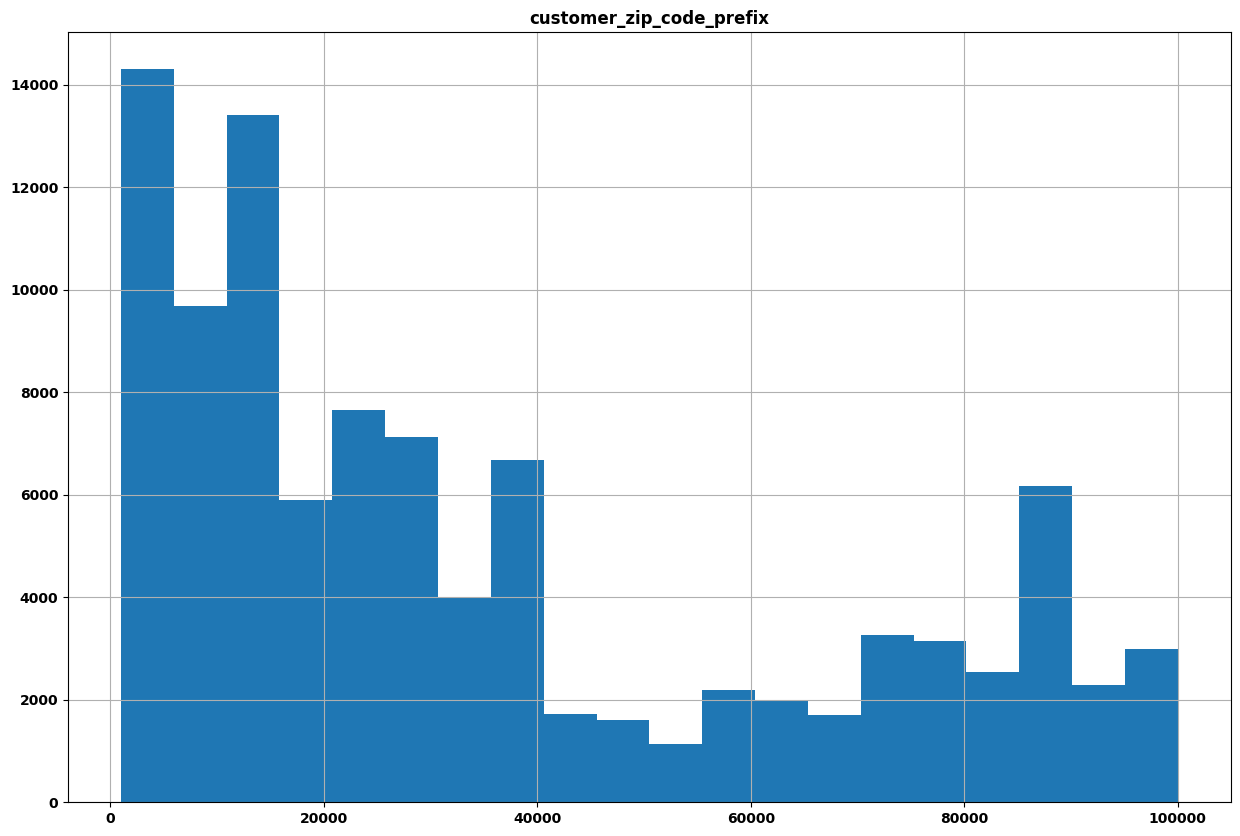

In [4]:
opening(df)

In [5]:
opening(df1)

ПЕРВЫЕ 5 СТРОК
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00         

In [ ]:
opening(df2)

ПЕРВЫЕ 5 СТРОК
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99    

**Выводы по разделу:**
- дубликатов нет, 
- пропуски есть в датафрейме с доставками (df1 - order_approved_at, order_delivered_carrier_date, order_delivered_customer_date).
- есть явные выбросы, но нам их удалять не нужно

<a id="предобработка"></a>
# 2. Предобработка данных

Изменим тип данных в customer_zip_code_prefix и order_item_id, так как это не числовой признак, о чем-то нам говорящий

In [ ]:
df['customer_zip_code_prefix'] = df['customer_zip_code_prefix'].astype('object')
df2['order_item_id'] = df2['order_item_id'].astype('object')
df.head()

In [ ]:
plt.figure(figsize=(10,6))
plt.boxplot(df2['freight_value'])
plt.title('Распределение стоимости доставки')
plt.ylabel('Стоимость доставки (руб.)')
plt.xticks([1], [' '])
plt.grid(True);

In [ ]:
plt.figure(figsize=(10,6))
plt.boxplot(df2['price'])
plt.title('Распределение цены')
plt.ylabel('Цена')
plt.xticks([1], [' '])
plt.grid(True);

Есть выбросы, но нам они не мешают при дальнейшем анализе

<a id="анализ"></a>
# 3. Анализ данных

## 1. Сколько пользователей, которые совершили покупку только один раз?

Сначала объединим таблицы с покупателями и заказами по customer_id

In [ ]:
dfz = df.merge(df1, on='customer_id').query("order_status == ['processing', 'shipped', 'delivered']")
dfz.head()

Для подсчета пользователей, которые совершили покупку только один раз, нам нужно сгруппировать по поличеству по колонке customer_unique_id (уникальный идентификатор пользователя(аналог номера паспорта)). И оставить только тех пользователей, кто совершал только одну покупку

In [ ]:
dfz1 = (dfz.groupby('customer_unique_id', as_index=False).agg({'order_id':'count'}).query('order_id == 1'))

display(dfz1.head(3))
dfz1.customer_unique_id.shape

**Ответ - только одну покупку совершили 91814 пользователь**

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Сразу выделяем заказы, которые не были доставлены по колонке order_delivered_customer_date (время доставки заказа)

In [ ]:
dfz2 = df1[df1.order_delivered_customer_date.isna()]
dfz2.order_status.value_counts()

**Нам подходят только заказы со статусом canceled (отменён) и unavailable (недоступен)**. Из этих статусов доставки нас не интересует shipped (отправлен), invoiced (выставлен счет), processing (в обработке), delivered (доставлен), created (создан) и approved (подтвержден).

In [ ]:
dfz2 = df1[df1.order_delivered_customer_date.isna()].query("order_status == ['canceled', 'unavailable']")
dfz2['order_purchase_timestamp'] = pd.to_datetime(dfz2.order_purchase_timestamp.dt.strftime('%Y-%m'))

display(dfz2.head())
print(dfz2.shape)

In [ ]:
print(df1['order_purchase_timestamp'].min())
print(df1['order_purchase_timestamp'].max(), '\n')

print(dfz2['order_purchase_timestamp'].min())
print(dfz2['order_purchase_timestamp'].max())

И оригинальная таблица, и таблица с отмененными заказами начинается и заканчивается на один и тот же месяц. Значит проблем с индексами не будет, они все будут учтены в Pivot таблице

In [ ]:
dfz2_pivot = dfz2.pivot_table(index = 'order_purchase_timestamp', columns = 'order_status', values = 'order_id', aggfunc = 'count', fill_value=0)
dfz2_pivot.head()

In [ ]:
round(dfz2_pivot.mean(), 2)

**Ответ: В среднем в месяц отменяется 25.79 заказов, а недоступны чуть меньше : 25.38 заказа**

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается

Объединим 2 таблицы, из первой нам нужна дата, из второй id товаров. И оставляем только заказы со статусом processing, shipped, delivered. И сразу переводим дату в день недели

In [ ]:
dfz3 = df1.merge(df2).query("order_status == ['processing', 'shipped', 'delivered']")
dfz3['order_day'] = dfz3.order_purchase_timestamp.dt.day_name()
dfz3.head()

Группируем все товары, узнаем как часто их покупали в каждый из дней недели.

In [ ]:
dfz3_product = dfz3.groupby(['product_id','order_day'], as_index=False).agg({'customer_id':'count'}) \
    .rename(columns={'customer_id':'sales'}).sort_values(by='product_id')
dfz3_product

In [ ]:
dfz3_product['max_sales'] = dfz3_product.groupby('product_id')['sales'].transform('max')
dfz3_product

In [ ]:
dfz3_product = dfz3_product[dfz3_product['sales'] == dfz3_product['max_sales']]
dfz3_product = dfz3_product[['product_id', 'order_day', 'sales']]
dfz3_product

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

для начала нужно объединить все три таблицы, так как нам нужны столбцы в каждой из них. И сразу переводим колонку в формат ГГ-ММ. 
Нам нужны только "покупки". То есть order_status (статус) = delivered (доставлено)

In [ ]:
dfz4 = df.merge(df1, on='customer_id', how = 'left')
dfz4 = dfz4.merge(df2, on='order_id', how = 'left')
dfz4['order_purchase_timestamp'] = pd.to_datetime(dfz4['order_purchase_timestamp'].dt.strftime('%Y-%m'))
dfz4 = dfz4[dfz4['order_status'] == 'delivered']
dfz4

Группируем данные по клиенту, данные о месяце покупок и их количестве. Сделаем столбец с месяцем покупки и с количеством недель в месяце

In [ ]:
dfz4 = dfz4.groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index=False).agg({'product_id':'count'})
dfz4['days_in_month'] = dfz4['order_purchase_timestamp'].dt.days_in_month
dfz4['weeks_in_month'] = dfz4['days_in_month'] / 7
dfz4.head()

Создаем столбец с количеством покупок клиента в неделю (по месяцам)

In [ ]:
dfz4['prurchase/week'] = dfz4['product_id'] / dfz4['weeks_in_month']
dfz4

## 5. Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц

Нужно объединить первую и вторую таблицу. Нам нужна колонка уникальный идентификатор пользователя и время покупки заказа. Оставляем только оплаченные заказы. И переведем order_purchase_timestamp в формат ГГ-ММ

In [ ]:
dfz5 = df.merge(df1, on='customer_id').query("order_status == ['processing', 'shipped', 'delivered']")
dfz5['order_purchase_timestamp'] = dfz5['order_purchase_timestamp'].dt.strftime('%Y-%m')
dfz5.head()

Cоздаем столбец cohort, в которым для каждого пользователя запишем дату его первой покупки. И оставим данные только за 2017, он подходит по условиям задачи

In [ ]:
dfz5.loc[:, 'cohort'] = dfz5.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')
dfz5 = dfz5[(dfz5['cohort'] > '2016-12') & (dfz5['cohort'] < '2018-01')]
dfz5.head()

Группируем по когортам

In [ ]:
dfz5_cohort = dfz5.groupby(['cohort', 'order_purchase_timestamp'], as_index=False).agg({'customer_unique_id': 'nunique'})
dfz5_cohort.head()

Переведем колонки с датами в datetime и выведем новую колонку период

In [ ]:
dfz5_cohort['cohort'] = pd.to_datetime(dfz5_cohort['cohort'])
dfz5_cohort['order_purchase_timestamp'] = pd.to_datetime(dfz5_cohort['order_purchase_timestamp'])

dfz5_cohort['cohort'] = dfz5_cohort['cohort'].dt.to_period('M')
dfz5_cohort['order_purchase_timestamp'] = dfz5_cohort['order_purchase_timestamp'].dt.to_period('M')


dfz5_cohort['cohort_period'] = (
    (dfz5_cohort['order_purchase_timestamp'].dt.year - dfz5_cohort['cohort'].dt.year) * 12 + 
     (dfz5_cohort['order_purchase_timestamp'].dt.month - dfz5_cohort['cohort'].dt.month)
)
dfz5_cohort

Делаем новую таблицу pivot с когортой по месяцам

In [ ]:
dfz5_pivot = dfz5_cohort.pivot(index='cohort', columns = 'cohort_period', values = 'customer_unique_id')
dfz5_pivot

Рассчитываем когорту на каждый месяц в таблицу. Нас интересует третий месяц (период 2)

In [ ]:
retention = round(dfz5_pivot.divide(dfz5_pivot[0], axis=0) * 100, 2)
retention

Нам нужна самая высокая когорта третьего месяца

In [ ]:
print(retention[2].idxmax())
print(retention[2].max())

**ОТВЕТ: наибольшая когорта (0.54%) на 3-ий месяц в 2017 году была зафиксирована в сентябре**

## 6.Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

15/23  
•	Используя стандартный подход в распределении Frequency по квантилям, ты в итоге получаешь всего два кластера - 1 и 5. Здесь стоит использовать индивидуальный подход и задать границы вручную - минус 4 балла.  

Объединяем все таблицы и удаляем пропуски

In [ ]:
dfz6 = df.merge(df1, on='customer_id')
dfz6 = dfz6.merge(df2, on='order_id').dropna()
dfz6

Нам нужно взять дату, которая будет означать "по сегодняшний день". Берем последний день данных и прибавляем день. c
Coздаём таблицу RFM. R - время от последней покупки пользователя до текущей даты,
F - суммарное количество покупок у пользователя за всё время, M - стоимость покупок за всё время

In [ ]:
now = dfz6.order_purchase_timestamp.max() + timedelta(days=1)

RFM = dfz6.groupby('customer_unique_id') \
    .agg({'order_purchase_timestamp': lambda x: (now - x.max()).days, 
          'order_id': 'nunique', 
          'price': 'sum'
         }).rename(columns={'order_purchase_timestamp': 'R', 'order_id': 'F', 'price': 'M'})
RFM

Разобьем на диапазон от 1 до 5: до 20, 20-40, 40-60, 60-80 и выше 80 %. Но это только для recency и monetary. В Frequency у нас у всех почти 1 заказ, поэтому там нужно разбить вручную

In [ ]:
RFM_seg = RFM.quantile(q=[0.20, 0.40, 0.60, 0.80]).to_dict()
RFM_seg

In [ ]:
def to_seg (a,b,c):
    if a <= c[b][0.2]:
        return 1
    elif a <= c[b][0.4]:
        return 2
    elif a <= c[b][0.6]:
        return 3
    elif a <= c[b][0.8]:
        return 4
    else:
        return 5

In [ ]:
def F_seg_manual(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x <= 6:
        return 4
    else:
        return 5

In [ ]:
RFM['R_seg'] = RFM['R'].apply(to_seg, args=('R', RFM_seg))
RFM['F_seg'] = RFM['F'].apply(F_seg_manual)
RFM['M_seg'] = RFM['M'].apply(to_seg, args=('M', RFM_seg))

RFM['RFMseg'] = RFM['R_seg'].astype(str) + RFM['F_seg'].astype(str) + RFM['M_seg'].astype(str)
RFM

In [ ]:
RFM['RFMseg'].value_counts()

**Клиенты по RFM:   
R=1 - покупали недавно. R=5 - покупали давно  
F=1 - покупали редко   F=5 - покупали часто  
M=1 - платили мало   M=5 платили мало  
Много клиентов с R=4,5 и F,M=1,2. Это значит, что много клиентов, давно покупавших и мало плативших за минимальное количество товаров**

<a id="вывод"></a>
# 4. Вывод

- Выявлены одноразовые покупатели - их 91814 человек
- Количество недоставленных заказов в месяц по статусам canceled 25.79 заказов, а unavailable чуть меньше : 25.38
- Определено, в какой день недели каждый товар чаще всего покупается
- Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)
- Построен когортный анализ с retention по месяцам  
- Проведена RFM-сегментация клиентов для оценки лояльности и ценности клиентов